In [2]:
!pip install torchmetrics cuml-cu12 faiss-gpu-cu12

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 5.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (

In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchmetrics.image import StructuralSimilarityIndexMeasure

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.version.cuda)

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

cuda
12.4


In [4]:
# Load the image tensors (shape: [N, C, H, W])
train_images = torch.load('/content/drive/MyDrive/Colab Notebooks/Final_Project/train_images_tensor.pt')
test_images = torch.load('/content/drive/MyDrive/Colab Notebooks/Final_Project/test_images_tensor.pt')

# Create datasets where inputs and targets are the same.
train_dataset = TensorDataset(train_images, train_images)
test_dataset = TensorDataset(test_images, test_images)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

<ipython-input-4-aaafb3ce626d>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_images = torch.load('/content/drive/MyDrive/Colab Notebooks/Final_Project/train_images_

In [5]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),

            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),

            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),

            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [6]:
print('Training Data Size:', len(train_dataset))
print('Testing Data Size:', len(test_dataset))

print('\nTraining Data Batches:', len(train_loader))
print('Testing Data Batches', len(test_loader))

Training Data Size: 16000
Testing Data Size: 4000

Training Data Batches: 125
Testing Data Batches 32


In [7]:
def denormalize_tensor(tensor, mean, std):
    """
    Denormalize a tensor image.
    Assumes tensor shape is (B, C, H, W) or (C, H, W).
    """
    # If tensor has no batch dimension, add one for uniformity
    if tensor.dim() == 3:
        tensor = tensor.unsqueeze(0)

    mean = torch.tensor(mean, device=tensor.device).view(1, -1, 1, 1)
    std = torch.tensor(std, device=tensor.device).view(1, -1, 1, 1)

    denorm = tensor * std + mean
    return denorm.squeeze(0) if denorm.size(0) == 1 else denorm

denorm_mean = [0.0591, 0.0526, 0.0591]
denorm_std = [0.0936, 0.0823, 0.0838]

In [8]:
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 10

# Lists to store metrics per epoch
train_losses = []
mse_scores = []
ssim_scores = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # Training loop
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as pbar:
        for i, (inputs, targets) in enumerate(pbar):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Update the progress bar with the average loss so far
            avg_loss = running_loss / (i + 1)
            pbar.set_postfix(train_loss=f"{avg_loss:.3f}")

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluate MSE/SSIM on test data (using denormalized images)
    test_loss = 0.0
    ssim_metric_denorm = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
    ssim_metric_denorm.reset()

    model.eval()

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, targets)
            test_loss += loss.item()

            # Denormalize outputs and targets
            outputs_denorm = denormalize_tensor(outputs, denorm_mean, denorm_std)
            targets_denorm = denormalize_tensor(targets, denorm_mean, denorm_std)
            ssim_metric_denorm.update(outputs_denorm, targets_denorm)

    avg_test_mse = test_loss / len(test_loader)
    mse_scores.append(avg_test_mse)

    epoch_ssim = ssim_metric_denorm.compute().item()
    ssim_scores.append(epoch_ssim)

    tqdm.write(f"\t (test) | MSE: {avg_test_mse:.3f} | SSIM: {epoch_ssim:.3f}")

Epoch 1/20: 100%|██████████| 125/125 [00:15<00:00,  8.20batch/s, train_loss=0.540]


	 (test) | MSE: 0.396 | SSIM: 0.485


Epoch 2/20: 100%|██████████| 125/125 [00:13<00:00,  9.45batch/s, train_loss=0.300]


	 (test) | MSE: 0.253 | SSIM: 0.620


Epoch 3/20: 100%|██████████| 125/125 [00:13<00:00,  9.25batch/s, train_loss=0.198]


	 (test) | MSE: 0.157 | SSIM: 0.722


Epoch 4/20: 100%|██████████| 125/125 [00:13<00:00,  9.39batch/s, train_loss=0.136]


	 (test) | MSE: 0.124 | SSIM: 0.781


Epoch 5/20: 100%|██████████| 125/125 [00:13<00:00,  9.26batch/s, train_loss=0.116]


	 (test) | MSE: 0.107 | SSIM: 0.815


Epoch 6/20: 100%|██████████| 125/125 [00:13<00:00,  9.30batch/s, train_loss=0.104]


	 (test) | MSE: 0.098 | SSIM: 0.831


Epoch 7/20: 100%|██████████| 125/125 [00:13<00:00,  9.31batch/s, train_loss=0.094]


	 (test) | MSE: 0.099 | SSIM: 0.822


Epoch 8/20: 100%|██████████| 125/125 [00:13<00:00,  9.37batch/s, train_loss=0.088]


	 (test) | MSE: 0.085 | SSIM: 0.852


Epoch 9/20: 100%|██████████| 125/125 [00:13<00:00,  9.45batch/s, train_loss=0.081]


	 (test) | MSE: 0.078 | SSIM: 0.865


Epoch 10/20: 100%|██████████| 125/125 [00:13<00:00,  9.31batch/s, train_loss=0.076]


	 (test) | MSE: 0.073 | SSIM: 0.877


Epoch 11/20: 100%|██████████| 125/125 [00:13<00:00,  9.35batch/s, train_loss=0.074]


	 (test) | MSE: 0.069 | SSIM: 0.881


Epoch 12/20: 100%|██████████| 125/125 [00:13<00:00,  9.22batch/s, train_loss=0.068]


	 (test) | MSE: 0.066 | SSIM: 0.889


Epoch 13/20: 100%|██████████| 125/125 [00:13<00:00,  9.38batch/s, train_loss=0.065]


	 (test) | MSE: 0.063 | SSIM: 0.892


Epoch 14/20: 100%|██████████| 125/125 [00:13<00:00,  9.32batch/s, train_loss=0.062]


	 (test) | MSE: 0.060 | SSIM: 0.900


Epoch 15/20: 100%|██████████| 125/125 [00:13<00:00,  9.37batch/s, train_loss=0.060]


	 (test) | MSE: 0.058 | SSIM: 0.902


Epoch 16/20: 100%|██████████| 125/125 [00:13<00:00,  9.30batch/s, train_loss=0.059]


	 (test) | MSE: 0.056 | SSIM: 0.908


Epoch 17/20: 100%|██████████| 125/125 [00:13<00:00,  9.32batch/s, train_loss=0.056]


	 (test) | MSE: 0.054 | SSIM: 0.910


Epoch 18/20: 100%|██████████| 125/125 [00:13<00:00,  9.23batch/s, train_loss=0.054]


	 (test) | MSE: 0.052 | SSIM: 0.914


Epoch 19/20: 100%|██████████| 125/125 [00:13<00:00,  9.30batch/s, train_loss=0.053]


	 (test) | MSE: 0.052 | SSIM: 0.908


Epoch 20/20: 100%|██████████| 125/125 [00:13<00:00,  9.23batch/s, train_loss=0.052]


	 (test) | MSE: 0.049 | SSIM: 0.919


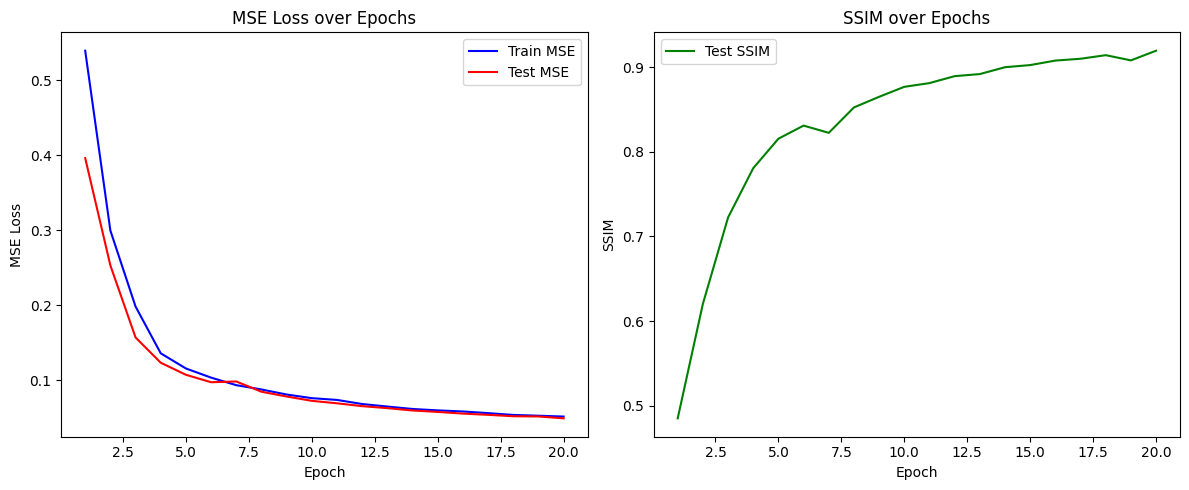

In [9]:
# Plotting the metrics over epochs
epochs = range(1, num_epochs+1)
plt.figure(figsize=(12, 5))

# Plot for MSE (Training and Test)
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-', label='Train MSE')
plt.plot(epochs, mse_scores, 'r-', label='Test MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('MSE Loss over Epochs')
plt.legend()

# Plot for SSIM
plt.subplot(1, 2, 2)
plt.plot(epochs, ssim_scores, 'g-', label='Test SSIM')
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.title('SSIM over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
model.eval()

# Initialize accumulators
n_pixels = 0
sum_in = torch.zeros(3)
sum_in_sq = torch.zeros(3)

sum_out = torch.zeros(3)
sum_out_sq = torch.zeros(3)

with torch.no_grad():
    for inputs, _ in tqdm(test_loader, desc="Computing global stats"):
        inputs = inputs.to(device)
        outputs = model(inputs)  # outputs assumed to be of shape [B, C, H, W]

        # Move both inputs and outputs to CPU
        inputs = inputs.cpu()
        outputs = outputs.cpu()

        # Get the number of pixels per channel for this batch
        b, c, h, w = outputs.shape
        n_pixels_batch = b * h * w
        n_pixels += n_pixels_batch

        # Sum over batch, height, and width for each channel
        sum_in += inputs.sum(dim=(0, 2, 3))
        sum_in_sq += (inputs ** 2).sum(dim=(0, 2, 3))

        sum_out += outputs.sum(dim=(0, 2, 3))
        sum_out_sq += (outputs ** 2).sum(dim=(0, 2, 3))


def finalize_mean_std(sum_, sum_sq, n_pixels):
    """
    Given accumulated sums and sums of squares (sum_ and sum_sq),
    plus the total pixel count (n_pixels), compute the mean and std
    in shape [1, C, 1, 1].
    """
    mean_1d = sum_ / n_pixels
    var_1d = (sum_sq / n_pixels) - mean_1d**2
    std_1d = torch.sqrt(var_1d)

    # Reshape to [1, C, 1, 1] if needed for broadcasting later
    mean_4d = mean_1d.view(1, -1, 1, 1)
    std_4d = std_1d.view(1, -1, 1, 1)
    return mean_4d, std_4d


global_inputs_mean, global_inputs_std = finalize_mean_std(sum_in, sum_in_sq, n_pixels)
global_outputs_mean, global_outputs_std = finalize_mean_std(sum_out, sum_out_sq, n_pixels)

print("\n\nGlobal Inputs:")
print("Mean:", global_inputs_mean.squeeze())
print("Std:", global_inputs_std.squeeze())

print("\nGlobal Outputs:")
print("Mean:", global_outputs_mean.squeeze())
print("Std:", global_outputs_std.squeeze())

Computing global stats: 100%|██████████| 32/32 [00:07<00:00,  4.52it/s]



Global Inputs:
Mean: tensor([0.0057, 0.0046, 0.0012])
Std: tensor([0.9800, 0.9680, 0.9523])

Global Outputs:
Mean: tensor([0.0064, 0.0126, 0.0002])
Std: tensor([0.9552, 0.9442, 0.9216])


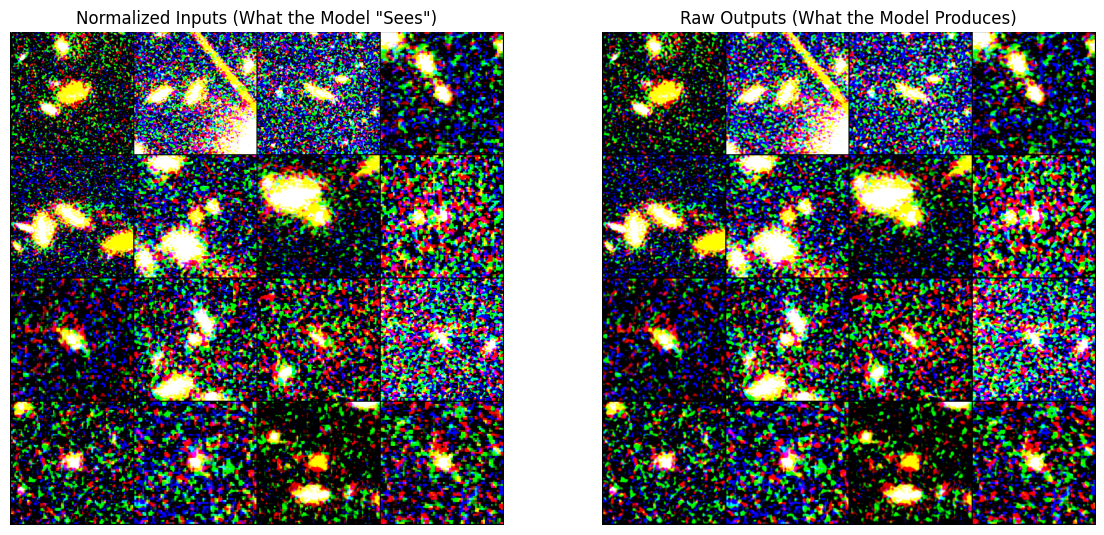

In [11]:
# Grab a batch of normalized inputs and get the raw outputs from the model.
with torch.no_grad():
    inputs, _ = next(iter(test_loader))
    inputs = inputs.to(device)
    outputs = model(inputs)

inputs = inputs.cpu()
outputs = outputs.cpu()

# Create grids of 16 images each, directly from the raw tensors
inputs_for_display = torch.clamp(inputs, 0, 1)
grid_inputs_norm = torchvision.utils.make_grid(inputs_for_display[:16], nrow=4)
outputs_for_display = torch.clamp(outputs, 0, 1)
grid_outputs_raw = torchvision.utils.make_grid(outputs_for_display[:16], nrow=4)

# Convert from (C, H, W) to (H, W, C) for plotting
grid_inputs_norm_np = grid_inputs_norm.permute(1, 2, 0).numpy()
grid_outputs_raw_np = grid_outputs_raw.permute(1, 2, 0).numpy()

# 5) Plot side by side
plt.figure(figsize=(14, 10))

plt.subplot(1, 2, 1)
plt.imshow(grid_inputs_norm_np)
plt.title("Normalized Inputs (What the Model \"Sees\")")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(grid_outputs_raw_np)
plt.title("Raw Outputs (What the Model Produces)")
plt.axis('off')

plt.show()

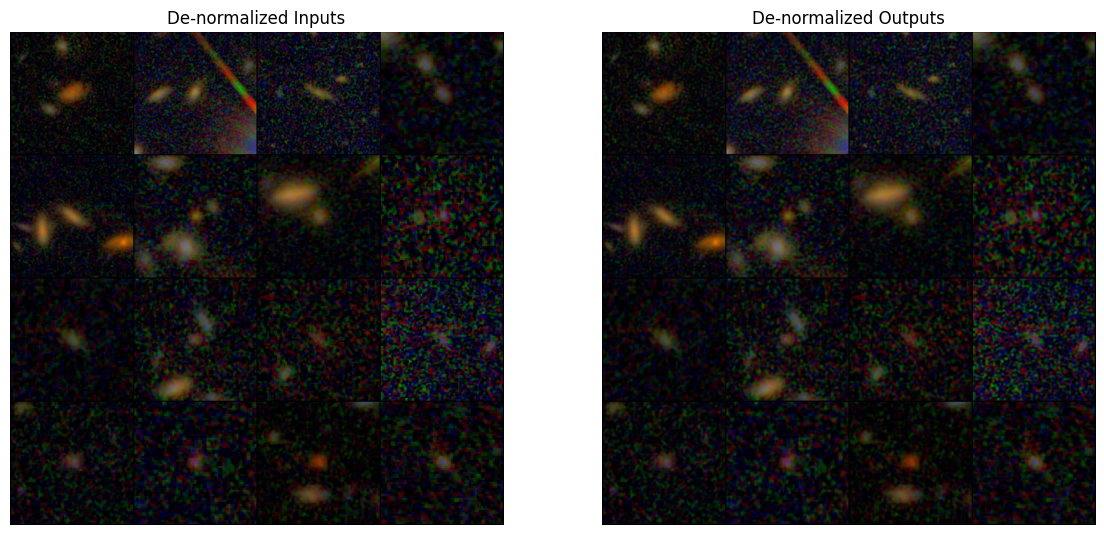

In [12]:
# De-normalize the tensors
inputs_denorm = denormalize_tensor(inputs, denorm_mean, denorm_std)
outputs_denorm = denormalize_tensor(outputs, denorm_mean, denorm_std)

# Clamp to ensure values are within [0, 1] for display
inputs_for_display = torch.clamp(inputs_denorm, 0, 1)
outputs_for_display = torch.clamp(outputs_denorm, 0, 1)

grid_inputs = torchvision.utils.make_grid(inputs_for_display[:16], nrow=4)
grid_outputs = torchvision.utils.make_grid(outputs_for_display[:16], nrow=4)

# Convert from (C, H, W) to (H, W, C) for plotting
grid_inputs_np = grid_inputs.permute(1, 2, 0).numpy()
grid_outputs_np = grid_outputs.permute(1, 2, 0).numpy()

plt.figure(figsize=(14, 10))

plt.subplot(1, 2, 1)
plt.imshow(grid_inputs_np)
plt.title("De-normalized Inputs")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(grid_outputs_np)
plt.title("De-normalized Outputs")
plt.axis('off')

plt.show()

In [14]:
# For denormalized images: we expect values in [0, 1]
ssim_metric_denorm = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

# Reset metric
ssim_metric_denorm.reset()

model.eval()

with torch.no_grad():
    for inputs, targets in tqdm(test_loader, desc="Evaluating SSIM"):
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)

        # Denormalize both outputs and targets before updating denorm SSIM
        outputs_denorm = denormalize_tensor(outputs, denorm_mean, denorm_std)
        targets_denorm = denormalize_tensor(targets, denorm_mean, denorm_std)
        ssim_metric_denorm.update(outputs_denorm, targets_denorm)

# Compute the final SSIM value
final_ssim_denorm = ssim_metric_denorm.compute()

print(f"De-normalized SSIM: {final_ssim_denorm.item():.3f}")

Evaluating SSIM: 100%|██████████| 32/32 [00:02<00:00, 11.05it/s]

De-normalized SSIM: 0.919
